# Challenge 1

In order to make this notebook cleaner, useful functions are stored in the `utils.py` file and models in the `models.py` file.

In [3]:
# Custom modules
from libs.utils import *
from libs.models import *

# Data manipulation
import pandas as pd
import numpy as np
from numpy.linalg import norm

# General
from tqdm.auto import tqdm
from tabulate import tabulate
from joblib import Parallel, delayed

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score, accuracy_score, confusion_matrix
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.svm import SVC

# Optimization
from scipy.optimize import linear_sum_assignment

# Deep learning
import torch
from torch.utils.data import Subset
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms


# Set the seed for reproducibility
SEED = 42
np.random.seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## Dataset

We begin by loading the Fashoin MNIST dataset, which is a dataset of Zalando's article images. It consists of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. For lack of time and computational resources, we will use only 10% of the training set.

In [4]:
downsample_factor = 0.1

df_train, df_val, df_test = load_mnist(SEED)

df_train, _ = train_test_split(df_train, test_size=1-downsample_factor, stratify=df_train["label"], random_state=SEED)

# Validation and Test set to have the same size of the training set
df_val = df_val.sample(frac=1).groupby("label").head(df_train.shape[0]//10)
df_test = df_test.sample(frac=1).groupby("label").head(df_train.shape[0]//10)

In [5]:
X_train, y_train = df_train.drop(columns='label').values, df_train['label'].values
X_val,   y_val   = df_val.drop(columns='label').values,   df_val['label'].values
X_test,  y_test  = df_test.drop(columns='label').values,  df_test['label'].values

Before proceeding with further operations, we standardize the dataset.

In [6]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## 1. Understanding data geometry

The first step of our pipeline consists of disentagle the original features in order to better understand the data geometry. In order to do so we perform the *Principal Component Analysis*. We test both linear and nonlinear PCAs.

We use the following kernels:
- Linear
- Gaussian
- Polynomial of degree 2
- Sigmoid

In [7]:
n_components = 10

### Linear PCA

In [8]:
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

expvar_ratio_linear = pca.explained_variance_ratio_
cumsum_expvar_ratio = np.cumsum(expvar_ratio_linear)

print(f'Number of features for 75% explained variance: {np.argmax(cumsum_expvar_ratio > 0.75)}')

Plots.plot_3D_interactive(X_train_pca, y_train)

Number of features for 75% explained variance: 0


### Gaussian PCA

In [9]:
kpca_gaussian = KernelPCA(n_components=n_components, kernel='rbf')
X_train_kpca_gaussian = kpca_gaussian.fit_transform(X_train)
X_val_kpca_gaussian = kpca_gaussian.transform(X_val)

expvar_ratio_gaussian = kpca_gaussian.eigenvalues_ / kpca_gaussian.eigenvalues_.sum()
cumsum_expvar_ratio = np.cumsum(expvar_ratio_gaussian)

print(f'Number of features for 75% explained variance: {np.argmax(cumsum_expvar_ratio > 0.75)}')

Plots.plot_3D_interactive(X_train_kpca_gaussian, y_train)

Number of features for 75% explained variance: 4


### Polynomial PCA

In [10]:
kpca_poly = KernelPCA(n_components=n_components, kernel='poly', degree=2)
X_train_kpca_poly = kpca_poly.fit_transform(X_train)
X_val_kpca_poly = kpca_poly.transform(X_val)

expvar_ratio_poly = kpca_poly.eigenvalues_ / kpca_poly.eigenvalues_.sum()
cumsum_expvar_ratio = np.cumsum(expvar_ratio_poly)

print(f'Number of features for 75% explained variance: {np.argmax(cumsum_expvar_ratio > 0.75)}')

Plots.plot_3D_interactive(X_train_kpca_poly, y_train)

Number of features for 75% explained variance: 5


### Sigmoid PCA

In [11]:
kpca_sigmoid = KernelPCA(n_components=n_components, kernel='sigmoid', gamma=1.386, coef0=0)
X_train_kpca_sigmoid = kpca_sigmoid.fit_transform(X_train)
X_val_kpca_sigmoid = kpca_sigmoid.transform(X_val)

expvar_ratio_sigmoid = kpca_sigmoid.eigenvalues_ / kpca_sigmoid.eigenvalues_.sum()
cumsum_expvar_ratio = np.cumsum(expvar_ratio_sigmoid)

print(f'Number of features for 75% explained variance: {np.argmax(cumsum_expvar_ratio > 0.75)}')

Plots.plot_3D_interactive(X_train_kpca_sigmoid, y_train)

Number of features for 75% explained variance: 3


### Custom Kernel PCA

So far we have tested popular and well known kernels that are often utilized. Now we would like to combine multiple kernels in order to create a custom one, hopefully improving the results.

---

**Theorem 1** *(MVA 2021 - J. Mairal & J.P. Vert)*

Forall $i = 1, 2, \dots, M$, let $\phi_i : \mathcal{X} \rightarrow \mathcal{H}_i$ be a feature map such that 
$$
    K_i (x, y) = \langle \phi_i(x), \phi_i(y) \rangle_{\mathcal{H}_i}
$$
Then the kernel $K$ defined by
$$
    K(x, y) = \sum_{i=1}^M \alpha_i K_i(x, y)
$$
can be expressed as
$$
    K(x, y) = \langle \phi_S(x), \phi_S(y) \rangle_{\mathcal{H}_S}
$$
where $\phi_S : \mathcal{X} \rightarrow \mathcal{H}_S = \mathcal{H}_1 \bigoplus \mathcal{H}_2 \bigoplus \dots \bigoplus \mathcal{H}_M$ is the **concatenation** of the feature maps $\phi_i$:
$$
    \phi_S(x) = \left[ \begin{array}{c} \phi_1(x) \\ \phi_2(x) \\ \vdots \\ \phi_M(x) \end{array} \right]
$$

---

This theorem allows us to combine multiple kernels into a single one with a weighted sum. As a result we are projecting the data into a higher dimensional space made of the concatenation of each individual feature map.

We use the joblib library to parallelize the computation of the custom kernel PCA.


In [12]:
def sigmoid_variant(x, y, gamma=1.386):
    cos = 1 + np.dot(x, y) / ((norm(x) * norm(y)) + 1e-8)
    return np.tanh(gamma * cos)

def gaussian(x, y, gamma=0.05):
    return np.exp(-gamma * np.dot(x - y, x - y))

def custom_kernel(x, y, sig_gamma=1.386, gauss_gamma=0.05, weights=np.ones(2)):
    # sigmoid kernel
    sigmoid_kernel = sigmoid_variant(x, y, gamma=sig_gamma)
    # gaussian kernel
    gaussian_kernel = gaussian(x, y, gamma=gauss_gamma)

    # Multiple kernels weighted combination
    kernels = np.array([sigmoid_kernel, gaussian_kernel])
    res = np.dot(kernels, weights)

    return res

In [13]:
# Define a function for parallel computation of a row
def compute_row(i, X1, X2):
    return [custom_kernel(X1[i], X2[j]) for j in range(X2.shape[0])]

# Training set
gram_mat_train = np.zeros((X_train.shape[0], X_train.shape[0]))
results_train   = Parallel(n_jobs=-1)(delayed(compute_row)(i, X_train, X_train) for i in tqdm(range(X_train.shape[0])))
gram_mat_train = np.array(results_train)

# Validation set
gram_mat_val = np.zeros((X_val.shape[0], X_train.shape[0]))
results_val  = Parallel(n_jobs=-1)(delayed(compute_row)(i, X_val, X_train) for i in tqdm(range(X_val.shape[0])))
gram_mat_val = np.array(results_val)

  0%|          | 0/4800 [00:00<?, ?it/s]

  0%|          | 0/4800 [00:00<?, ?it/s]

In [14]:
kpca_custom = KernelPCA(n_components=n_components, kernel='precomputed')
X_train_kpca_custom = kpca_custom.fit_transform(gram_mat_train)
X_val_kpca_custom = kpca_custom.transform(gram_mat_val)

expvar_ratio_custom = kpca_custom.eigenvalues_ / kpca_custom.eigenvalues_.sum()
cumsum_expvar_ratio = np.cumsum(expvar_ratio_custom)

print(f'Number of features for 75% explained variance: {np.argmax(cumsum_expvar_ratio > 0.75)}')

# Visualize first two components
Plots.plot_3D_interactive(X_train_kpca_custom, y_train)

Number of features for 75% explained variance: 2


In order to visualize the explained variance decay as the number of components increases, we show the display plot

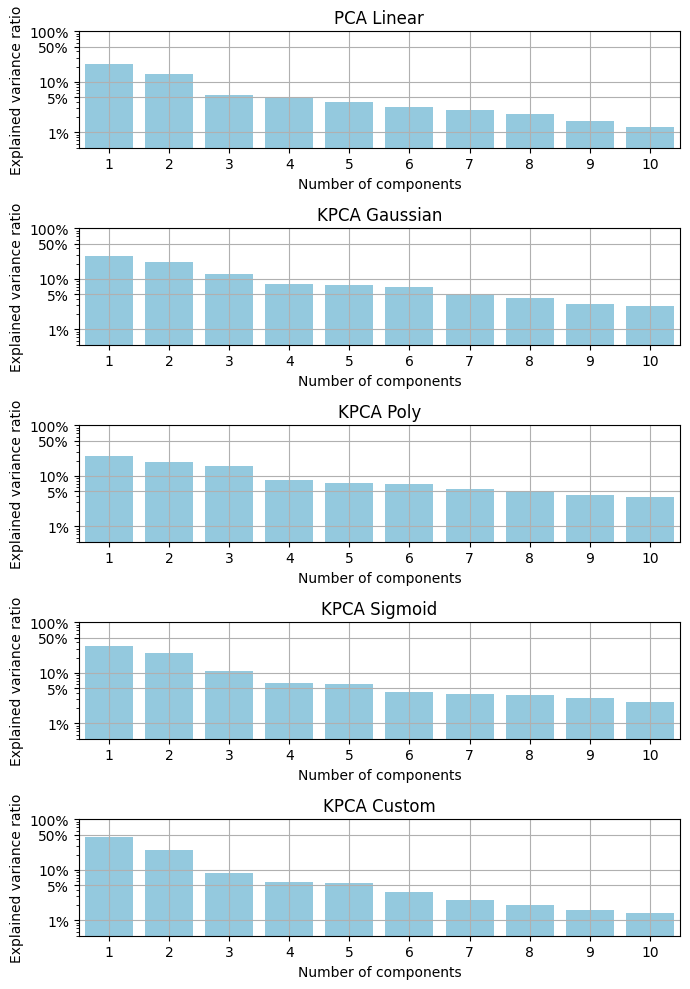

In [15]:
x_axis = np.arange(1, n_components+1)

# Plot of explained variance
fig, ax = plt.subplots(5, 1, figsize=(7, 10))
Plots.plot_explained_variance_ratio( x_axis, expvar_ratio_linear,     ax=ax[0], title="PCA Linear" )
Plots.plot_explained_variance_ratio( x_axis, expvar_ratio_gaussian,   ax=ax[1], title="KPCA Gaussian" )
Plots.plot_explained_variance_ratio( x_axis, expvar_ratio_poly,       ax=ax[2], title="KPCA Poly" )
Plots.plot_explained_variance_ratio( x_axis, expvar_ratio_sigmoid,    ax=ax[3], title="KPCA Sigmoid" )
Plots.plot_explained_variance_ratio( x_axis, expvar_ratio_custom,     ax=ax[4], title="KPCA Custom" )

plt.tight_layout()
plt.show()

In order to have a numeric value of performance of a decomposition, we can define the following quantities:

$$
\begin{align*}
    \text{decay}_i &= \frac{\text{explained\_variance}_i - \text{explained\_variance}_{i+1}}{\text{explained\_variance}_i} \\
    \text{HWMD} &= \frac{\sum_{i=1}^{n-1} \text{decay}_i \cdot \frac{1}{i}}{\sum_{i=1}^{n-1} \frac{1}{i}}
\end{align*}
$$

where the second one is the Harmonic Weighted Mean Decay of the explained variance. The idea is that the best decomposition is the one that has the highest average decay of the explained variance. In addition to this, we prefer a decomposition that has a faster decay.

In [16]:
decay_linear    = -np.diff(expvar_ratio_linear)     / expvar_ratio_linear[:-1]
decay_gaussian  = -np.diff(expvar_ratio_gaussian)   / expvar_ratio_gaussian[:-1]
decay_poly      = -np.diff(expvar_ratio_poly)       / expvar_ratio_poly[:-1]
decay_sigmoid   = -np.diff(expvar_ratio_sigmoid)    / expvar_ratio_sigmoid[:-1]
decay_custom    = -np.diff(expvar_ratio_custom)     / expvar_ratio_custom[:-1]

hmean_linear    = Metrics.harmonic_weighted_mean(decay_linear)
hmean_gaussian  = Metrics.harmonic_weighted_mean(decay_gaussian)
hmean_poly      = Metrics.harmonic_weighted_mean(decay_poly)
hmean_sigmoid   = Metrics.harmonic_weighted_mean(decay_sigmoid)
hmean_custom    = Metrics.harmonic_weighted_mean(decay_custom)

table = [
    ['PCA Linear'   , 100*hmean_linear],
    ['KPCA Gaussian', 100*hmean_gaussian],
    ['KPCA Poly'    , 100*hmean_poly],
    ['KPCA Sigmoid' , 100*hmean_sigmoid],
    ['KPCA Custom'  , 100*hmean_custom]
]
print(tabulate(table, headers=['Method', 'Harmonic Mean'], tablefmt='fancy_grid', floatfmt=".1f"))

╒═══════════════╤═════════════════╕
│ Method        │   Harmonic Mean │
╞═══════════════╪═════════════════╡
│ PCA Linear    │            31.3 │
├───────────────┼─────────────────┤
│ KPCA Gaussian │            25.1 │
├───────────────┼─────────────────┤
│ KPCA Poly     │            20.9 │
├───────────────┼─────────────────┤
│ KPCA Sigmoid  │            28.9 │
├───────────────┼─────────────────┤
│ KPCA Custom   │            38.2 │
╘═══════════════╧═════════════════╛


Finally we can choose the best decomposition

In [17]:
X_train_reduced = X_train_kpca_custom
X_val_reduced = X_val_kpca_custom

## 2. Bridging *unsupervised* and *supervised*

In this first phase we want to try to find the labels as we did not have them in the first place. We therefore proceed with a clustering of the data.

### Clustering

We assume we know the target feature is a categorical variable with 10 possible values. Now, we would like to perform a clustering analysis on the data and then find the best assignment of cluster labels to target feature labels.

Since we have the prior knoweldge on the number of cluster to be equal to 10, we choose to test the following clustering algorithms:
- KMeans
- Agglomerative Clustering
- Gaussian Mixture Model

In [18]:
n_clusters = len(np.unique(y_train))

kmeans = KMeans(n_clusters=n_clusters, random_state=SEED)
kmeans.fit(X_train_reduced)

agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
agglomerative.fit(X_train_reduced)

gmm = GaussianMixture(n_components=n_clusters, random_state=SEED)
gmm.fit(X_train_reduced)

clusters_kmeans = kmeans.predict(X_val_reduced)
clusters_agglo = agglomerative.fit_predict(X_val_reduced)
clusters_gmm = gmm.predict(X_val_reduced)

In [19]:
ari_kmeans = adjusted_rand_score(y_val, clusters_kmeans)
nmi_kmeans = normalized_mutual_info_score(y_val, clusters_kmeans)
silhouette_kmeans = silhouette_score(X_val_reduced, clusters_kmeans)
acc_kmeans = accuracy_score(y_val, clusters_kmeans)

ari_agglo = adjusted_rand_score(y_val, clusters_agglo)
nmi_agglo = normalized_mutual_info_score(y_val, clusters_agglo)
silhouette_agglo = silhouette_score(X_val_reduced, clusters_agglo)
acc_agglo = accuracy_score(y_val, clusters_agglo)

ari_gmm = adjusted_rand_score(y_val, clusters_gmm)
nmi_gmm = normalized_mutual_info_score(y_val, clusters_gmm)
silhouette_gmm = silhouette_score(X_val_reduced, clusters_gmm)
acc_gmm = accuracy_score(y_val, clusters_gmm)

table = [
    ['K-means', ari_kmeans, nmi_kmeans, silhouette_kmeans, acc_kmeans],
    ['Agglomerative', ari_agglo, nmi_agglo, silhouette_agglo, acc_agglo],
    ['GMM', ari_gmm, nmi_gmm, silhouette_gmm, acc_gmm]
]
print(tabulate(table, headers=['Method', 'ARI', 'NMI', 'Silhouette', 'Accuracy'], tablefmt='fancy_grid', floatfmt=".3f"))

╒═══════════════╤═══════╤═══════╤══════════════╤════════════╕
│ Method        │   ARI │   NMI │   Silhouette │   Accuracy │
╞═══════════════╪═══════╪═══════╪══════════════╪════════════╡
│ K-means       │ 0.342 │ 0.488 │        0.228 │      0.144 │
├───────────────┼───────┼───────┼──────────────┼────────────┤
│ Agglomerative │ 0.367 │ 0.512 │        0.198 │      0.043 │
├───────────────┼───────┼───────┼──────────────┼────────────┤
│ GMM           │ 0.411 │ 0.570 │        0.167 │      0.190 │
╘═══════════════╧═══════╧═══════╧══════════════╧════════════╛


All the metrics suggests that the best clustering algorithm is the Gaussian Mixture Model. We can now proceed with the supervised learning.

In [20]:
clusters = clusters_kmeans

### Supervised Learning

Now that we have identified the 10 clusters, we have to find the best assignment of cluster labels to target feature labels.
From the documentation of the dataset we know that the labels are:

0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot

We proceed by visualizing some data points for each cluster and manually assign the target feature label to each cluster.

<!-- This problem can be solved in polynomial time with the "Hungarian algorithm", developed in 1955 by Harold Kuhn.

We can use the negative confusion matrix as cost matrix. This means that the cost of assigning the cluster i to the target feature j is the negative accuracy of this assignment.

A simple example with two clusters and two target features is shown below:

| |Feature 1|Feature 2|
|-|-|-|
|Cluster 1|-0.9|-0.1|
|Cluster 2|-0.1|-0.9|

Assigning Cluster 1 to Feature 1 and Cluster 2 to Feature 2 would result in a cost of -0.9 - 0.9 = -1.8, 
while assigning Cluster 1 to Feature 2 and Cluster 2 to Feature 1 would result in a cost of -0.1 - 0.1 = -0.2.
Thus, the best assignment is Cluster 1 to Feature 2 and Cluster 2 to Feature 1.

Formally, given a cost matrix $C$, the Hungarian algorithm finds a permutation matrix $P$ that minimizes the cost function $\text{tr}(C^T P)$. -->

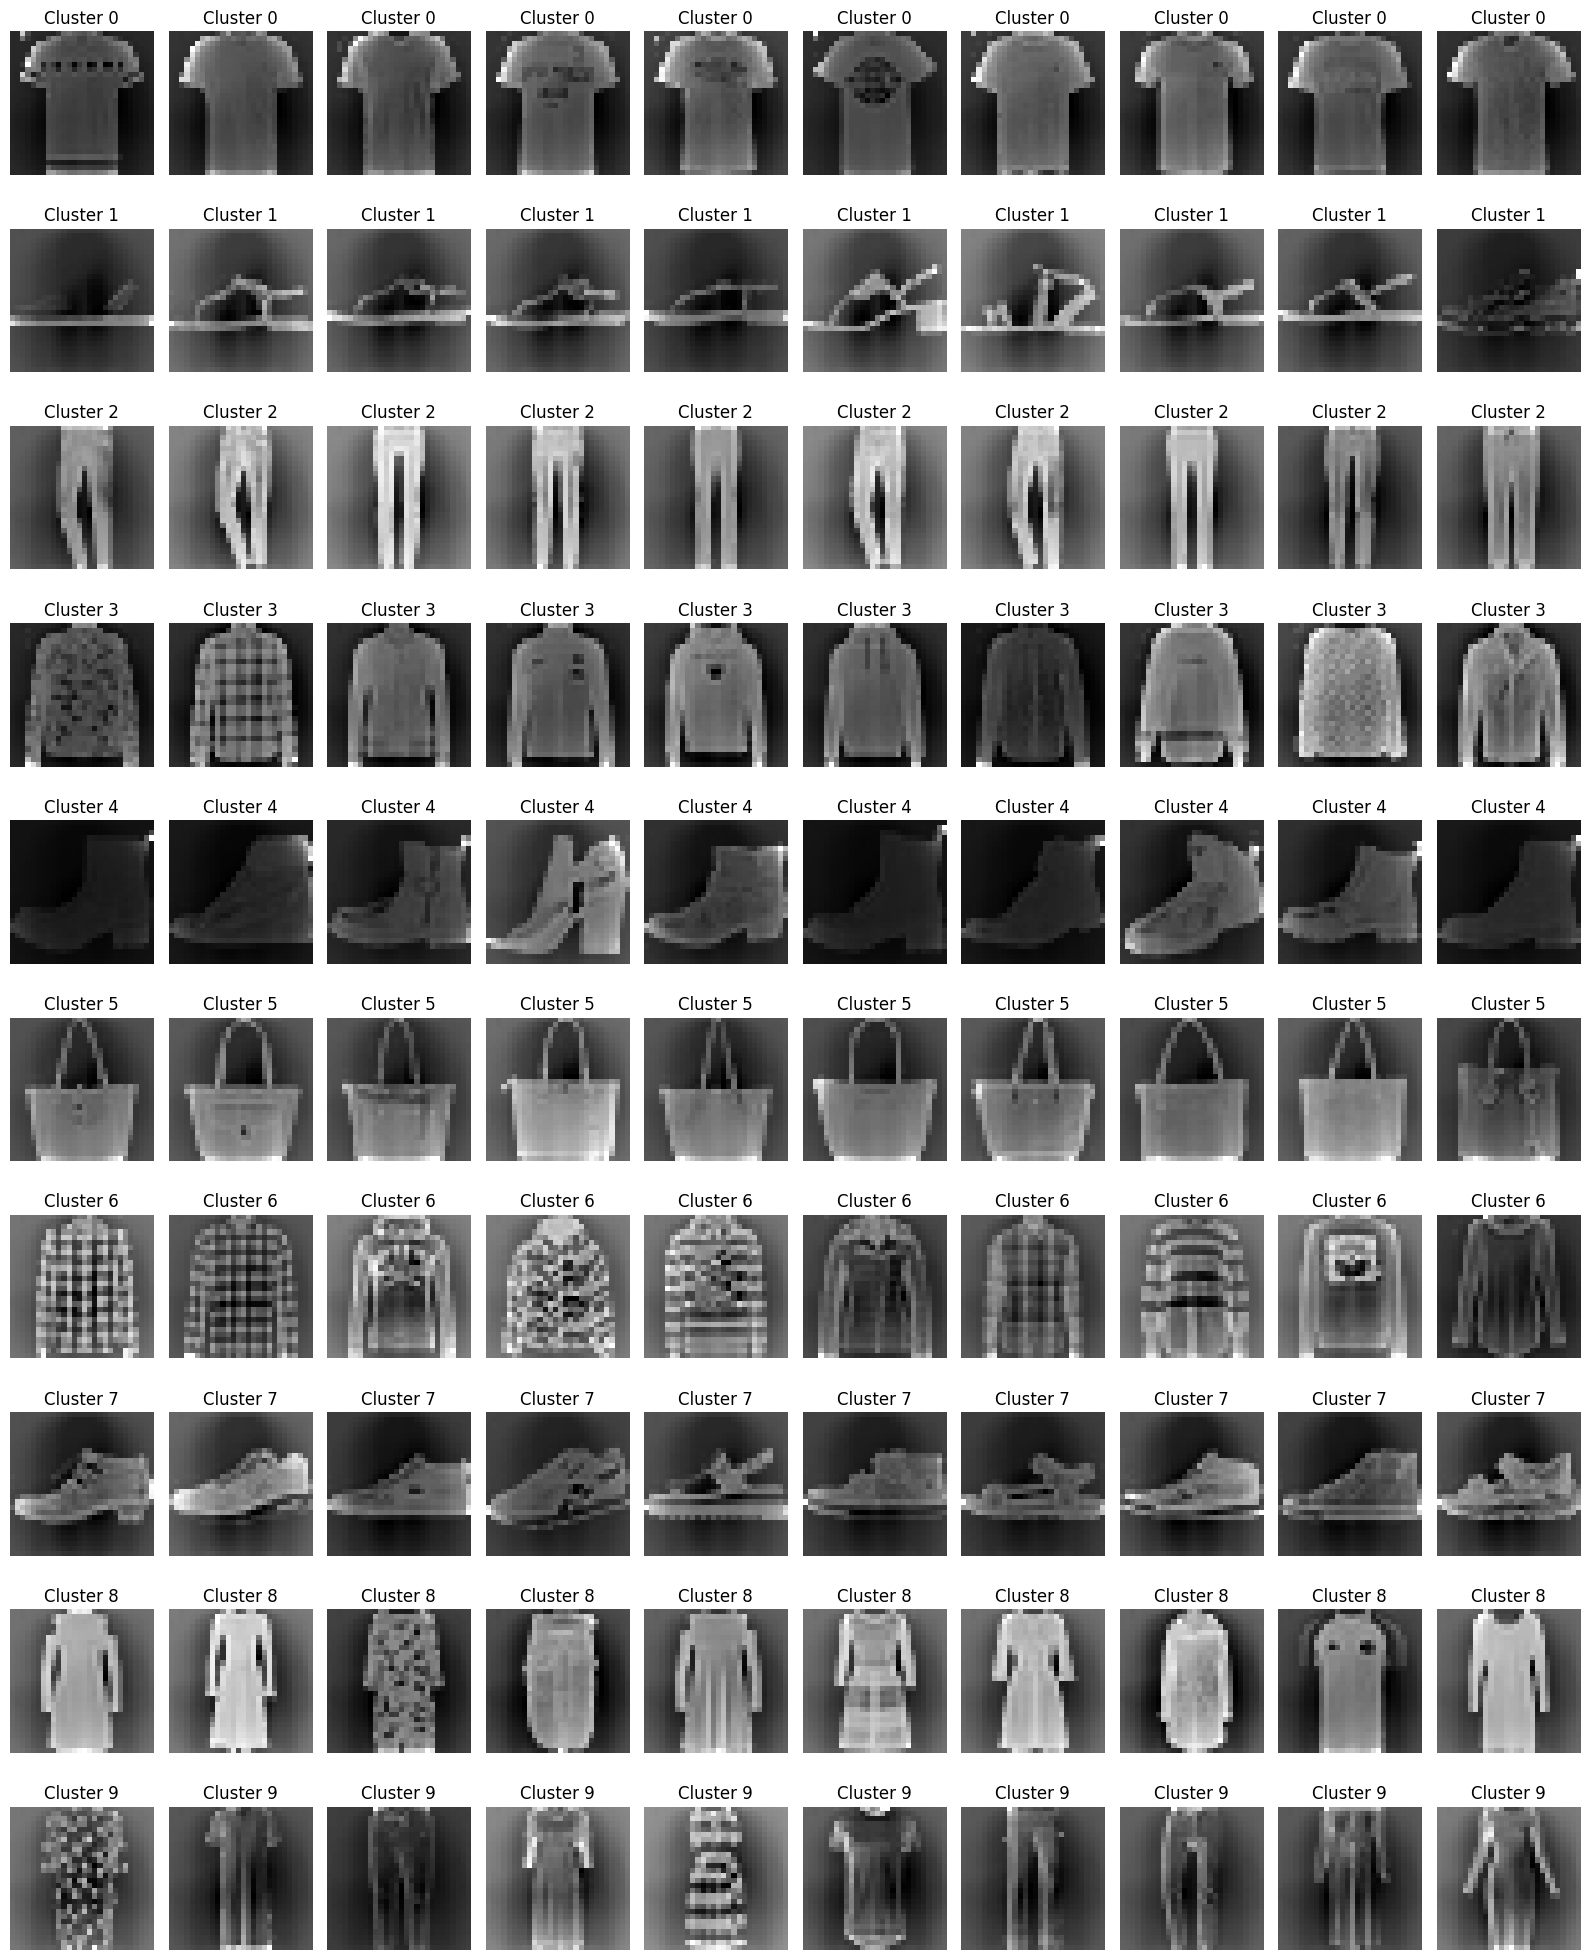

In [21]:
# For each cluster, get the mode and display the image
samples_per_cluster = 10
fig, ax = plt.subplots(n_clusters, samples_per_cluster, figsize=(16, 20))
for i in range(n_clusters):
    centroid = kmeans.cluster_centers_[i]
    distances = np.linalg.norm(X_val_reduced - centroid, axis=1)
    idx = np.argsort(distances)[:samples_per_cluster]
    for j in range(len(idx)):
        ax[i, j].imshow(X_val[idx[j]].reshape(28, 28), cmap='gray')
        ax[i, j].set_title(f'Cluster {clusters[idx[j]]}')
        ax[i, j].axis('off')

plt.tight_layout()
plt.show()

Since some part of the assignment is not very clear, we test multiple assignments and choose the one that gives the best accuracy.

In [22]:
assignment = [0, 5, 1, -1, 9, 8, -1, 7, -1, -1]
leftover = [i for i in range(n_clusters) if i not in assignment]

from itertools import permutations

assignments = []
for permutation in permutations(leftover):
    assignment_copy = assignment.copy()
    for i, p in enumerate(permutation):
        assignment_copy[assignment_copy.index(-1)] = p
    assignments.append(assignment_copy)

In [23]:
accs = []

for assignment in assignments:
    clusters_mapped = [assignment[c] for c in clusters]
    acc = accuracy_score(y_val, clusters_mapped)
    accs.append(acc)

best_assignment = assignments[np.argmax(accs)]
print(f'Best assignment: {best_assignment}')

y_pred_unsup = np.array([best_assignment[c] for c in clusters])

cluster_to_label = {i: best_assignment[i] for i in range(n_clusters)}
for i in range(n_clusters):
    print(f'Cluster {i} -> Label {cluster_to_label[i]}')

train_acc = accuracy_score(y_train, [cluster_to_label[c] for c in kmeans.labels_])
val_acc = accuracy_score(y_val, [cluster_to_label[c] for c in clusters])
print(f"Training Accuracy: {train_acc:.2f}")
print(f"Validation Accuracy: {val_acc:.2f}")

Best assignment: [0, 5, 1, 4, 9, 8, 2, 7, 3, 6]
Cluster 0 -> Label 0
Cluster 1 -> Label 5
Cluster 2 -> Label 1
Cluster 3 -> Label 4
Cluster 4 -> Label 9
Cluster 5 -> Label 8
Cluster 6 -> Label 2
Cluster 7 -> Label 7
Cluster 8 -> Label 3
Cluster 9 -> Label 6
Training Accuracy: 0.52
Validation Accuracy: 0.53


## 3. Supervised classification

We now train a classifier on the training data. However, we do not use the true labels for training, but the cluster labels obtained in the previous step. We then test it on the validation data.

### Kernel SVM

In [24]:
ksvm_linear   = SVC(kernel='linear', C=1, random_state=SEED)
ksvm_poly     = SVC(kernel='poly', degree=3, C=1, gamma='scale', random_state=SEED)
ksvm_gaussian = SVC(kernel='rbf', C=1, gamma='scale', random_state=SEED)
ksvm_sigmoid  = SVC(kernel='sigmoid', C=1, gamma='scale', random_state=SEED)

ksvm_linear.fit(X_train_reduced, y_pred_unsup)
ksvm_poly.fit(X_train_reduced, y_pred_unsup)
ksvm_gaussian.fit(X_train_reduced, y_pred_unsup)
ksvm_sigmoid.fit(X_train_reduced, y_pred_unsup)

SVC(C=1, kernel='sigmoid', random_state=42)

In [25]:
y_pred_train_linear = ksvm_linear.predict(X_train_reduced)
y_pred_val_linear = ksvm_linear.predict(X_val_reduced)

y_pred_train_poly = ksvm_poly.predict(X_train_reduced)
y_pred_val_poly = ksvm_poly.predict(X_val_reduced)

y_pred_train_gaussian = ksvm_gaussian.predict(X_train_reduced)
y_pred_val_gaussian = ksvm_gaussian.predict(X_val_reduced)

y_pred_train_sigmoid = ksvm_sigmoid.predict(X_train_reduced)
y_pred_val_sigmoid = ksvm_sigmoid.predict(X_val_reduced)

table = [
    ['SVM (Linear)', 100*accuracy_score(y_pred_unsup, y_pred_train_linear), 100*accuracy_score(y_val, y_pred_val_linear)],
    ['SVM (Poly)', 100*accuracy_score(y_pred_unsup, y_pred_train_poly), 100*accuracy_score(y_val, y_pred_val_poly)],
    ['SVM (Gaussian)', 100*accuracy_score(y_pred_unsup, y_pred_train_gaussian), 100*accuracy_score(y_val, y_pred_val_gaussian)],
    ['SVM (Sigmoid)', 100*accuracy_score(y_pred_unsup, y_pred_train_sigmoid), 100*accuracy_score(y_val, y_pred_val_sigmoid)]
]
print(tabulate(table, headers=['Model', 'Training Accuracy', 'Validation Accuracy'], tablefmt='fancy_grid', floatfmt=".1f"))

╒════════════════╤═════════════════════╤═══════════════════════╕
│ Model          │   Training Accuracy │   Validation Accuracy │
╞════════════════╪═════════════════════╪═══════════════════════╡
│ SVM (Linear)   │                15.2 │                  19.0 │
├────────────────┼─────────────────────┼───────────────────────┤
│ SVM (Poly)     │                18.7 │                   6.9 │
├────────────────┼─────────────────────┼───────────────────────┤
│ SVM (Gaussian) │                18.5 │                   6.7 │
├────────────────┼─────────────────────┼───────────────────────┤
│ SVM (Sigmoid)  │                 9.3 │                  10.0 │
╘════════════════╧═════════════════════╧═══════════════════════╛


### Multi-layer perceptron

We first perform one-hot encoding of the target feature. We then train a multi-layer perceptron on the training data and test it on the validation data.

In [26]:
encoder = OneHotEncoder(sparse_output=False)

y_train_unsup_onehot = encoder.fit_transform(y_pred_unsup.reshape(-1, 1))
y_val_unsup_onehot = encoder.fit_transform(y_val.reshape(-1, 1))

In [27]:
train_loader, val_loader = build_data_loaders(
    X_train_reduced,
    y_train_unsup_onehot,
    X_val_reduced,
    y_val_unsup_onehot,
    64
)

In [28]:
input_dim = X_train_reduced.shape[1]
hidden_dim = 128
output_dim = 10
num_layers = 4
activation = nn.ReLU
dropout = 0.1

model = MLP(input_dim, hidden_dim, output_dim, n_layers=num_layers, activation=activation, dropout=dropout).to(device)
print(f"Number of parameters: {model.num_params:.2E}")

Number of parameters: 6.98E+04


In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-3, betas=(0.99, 0.999))
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

train_losses, val_losses, lr_evolution = train(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    criterion = nn.CrossEntropyLoss(),
    optimizer = optimizer,
    lr_scheduler = lr_scheduler,
    n_epochs = 150,
    grad_clip = 1.0,
    device = device
)

Progress:  19%|█▊        | 28/150 [00:05<00:24,  4.94it/s, Train Loss=2.28, Val Loss=2.31]

Early stopping triggered!


Final training loss: 2.2791338539123536
Final validation loss: 2.308560053507487


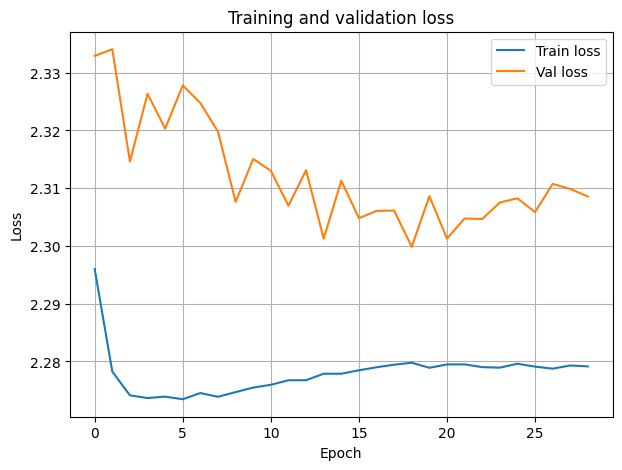

In [30]:
Plots.loss_plot(train_losses, val_losses)

In [31]:
model.eval()
mlp_train_acc = compute_accuracy(model, train_loader, device)
mlp_val_acc = compute_accuracy(model, val_loader, device)

### Convolutional neural network

This time we use a convolutional neural network to classify the data. Since we want to perform 2D convolution, we reshape the data back to 2D.

In [32]:
train_loader, val_loader = build_data_loaders(
    X_train_reduced.reshape(-1, 1, 5, 2),
    y_train_unsup_onehot,
    X_val_reduced.reshape(-1, 1, 5, 2),
    y_val_unsup_onehot,
    64,
    torch.float32,
    torch.float32
)

In [33]:
pre_hidden_dim = 64
hidden_dim = 64
output_dim = 10
n_mlp_layers=2
conv_activation=nn.ReLU
mlp_activation=nn.ReLU
dropout=0.0

model = CNN(pre_hidden_dim, hidden_dim, output_dim, n_mlp_layers, conv_activation, mlp_activation, dropout).to(device)
print(f"Number of parameters: {model.num_params:.2E}")

Number of parameters: 2.40E+04


In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-3, betas=(0.99, 0.999))
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

train_losses, val_losses, lr_evolution = train(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    criterion = nn.CrossEntropyLoss(),
    optimizer = optimizer,
    lr_scheduler = lr_scheduler,
    n_epochs = 100,
    grad_clip = 1.0,
    device = device
)

Progress:  21%|██        | 21/100 [00:05<00:21,  3.61it/s, Train Loss=2.3, Val Loss=2.3]

Early stopping triggered!


Final training loss: 2.2976420879364015
Final validation loss: 2.3031880187988283


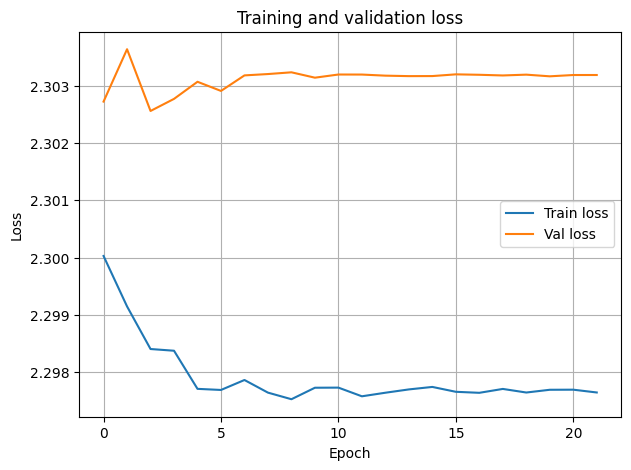

In [35]:
Plots.loss_plot(train_losses, val_losses)

In [36]:
model.eval()
cnn_train_acc = compute_accuracy(model, train_loader, device)
cnn_val_acc = compute_accuracy(model, val_loader, device)

#### Comparison

In [37]:
table = [
    ['SVM (Poly)', 100*accuracy_score(y_train, y_pred_train_poly), 100*accuracy_score(y_val, y_pred_val_poly)],
    ['SVM (Gaussian)', 100*accuracy_score(y_train, y_pred_train_gaussian), 100*accuracy_score(y_val, y_pred_val_gaussian)],
    ['SVM (Sigmoid)', 100*accuracy_score(y_train, y_pred_train_sigmoid), 100*accuracy_score(y_val, y_pred_val_sigmoid)],
    ['MLP', 100*mlp_train_acc, 100*mlp_val_acc],
    ['CNN', 100*cnn_train_acc, 100*cnn_val_acc]
]

print(tabulate(table, headers=['Model', 'Training Accuracy', 'Validation Accuracy'], tablefmt='fancy_grid', floatfmt='.1f'))

╒════════════════╤═════════════════════╤═══════════════════════╕
│ Model          │   Training Accuracy │   Validation Accuracy │
╞════════════════╪═════════════════════╪═══════════════════════╡
│ SVM (Poly)     │                 7.5 │                   6.9 │
├────────────────┼─────────────────────┼───────────────────────┤
│ SVM (Gaussian) │                 6.6 │                   6.7 │
├────────────────┼─────────────────────┼───────────────────────┤
│ SVM (Sigmoid)  │                 9.4 │                  10.0 │
├────────────────┼─────────────────────┼───────────────────────┤
│ MLP            │                14.8 │                  10.0 │
├────────────────┼─────────────────────┼───────────────────────┤
│ CNN            │                14.8 │                  10.0 │
╘════════════════╧═════════════════════╧═══════════════════════╛


## 5. Fully supervised classification

### Kernel SVM

In [38]:
ksvm_linear.fit(X_train_reduced, y_train)
ksvm_poly.fit(X_train_reduced, y_train)
ksvm_gaussian.fit(X_train_reduced, y_train)
ksvm_sigmoid.fit(X_train_reduced, y_train)

SVC(C=1, kernel='sigmoid', random_state=42)

In [39]:
y_pred_train_linear = ksvm_linear.predict(X_train_reduced)
y_pred_val_linear = ksvm_linear.predict(X_val_reduced)

y_pred_train_poly3 = ksvm_poly.predict(X_train_reduced)
y_pred_val_poly3 = ksvm_poly.predict(X_val_reduced)

y_pred_train_gaussian = ksvm_gaussian.predict(X_train_reduced)
y_pred_val_gaussian = ksvm_gaussian.predict(X_val_reduced)

y_pred_train_sigmoid = ksvm_sigmoid.predict(X_train_reduced)
y_pred_val_sigmoid = ksvm_sigmoid.predict(X_val_reduced)

table = [
    ['SVM (Linear)', 100*accuracy_score(y_train, y_pred_train_linear), 100*accuracy_score(y_val, y_pred_val_linear)],
    ['SVM (Poly)', 100*accuracy_score(y_train, y_pred_train_poly3), 100*accuracy_score(y_val, y_pred_val_poly3)],
    ['SVM (Gaussian)', 100*accuracy_score(y_train, y_pred_train_gaussian), 100*accuracy_score(y_val, y_pred_val_gaussian)],
    ['SVM (Sigmoid)', 100*accuracy_score(y_train, y_pred_train_sigmoid), 100*accuracy_score(y_val, y_pred_val_sigmoid)]
]
print(tabulate(table, headers=['Model', 'Training Accuracy', 'Validation Accuracy'], tablefmt='fancy_grid', floatfmt=".1f"))

╒════════════════╤═════════════════════╤═══════════════════════╕
│ Model          │   Training Accuracy │   Validation Accuracy │
╞════════════════╪═════════════════════╪═══════════════════════╡
│ SVM (Linear)   │                78.0 │                  76.4 │
├────────────────┼─────────────────────┼───────────────────────┤
│ SVM (Poly)     │                83.2 │                  80.4 │
├────────────────┼─────────────────────┼───────────────────────┤
│ SVM (Gaussian) │                83.6 │                  81.1 │
├────────────────┼─────────────────────┼───────────────────────┤
│ SVM (Sigmoid)  │                65.2 │                  64.5 │
╘════════════════╧═════════════════════╧═══════════════════════╛


### Multi-layer perceptron

In [40]:
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
y_val_onehot = encoder.fit_transform(y_val.reshape(-1, 1))

In [41]:
train_loader, val_loader = build_data_loaders(
    X_train_reduced,
    y_train_onehot,
    X_val_reduced,
    y_val_onehot,
    64,
    torch.float32,
    torch.float32
)

In [42]:
input_dim = X_train_reduced.shape[1]
hidden_dim = 128
output_dim = 10
num_layers = 4
activation = nn.ReLU
dropout = 0.05

model = MLP(input_dim, hidden_dim, output_dim, n_layers=num_layers, activation=activation, dropout=dropout).to(device)
print(f"Number of parameters: {model.num_params:.2E}")

Number of parameters: 6.98E+04


In [43]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4, betas=(0.99, 0.999))
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

train_losses, val_losses, lr_evolution = train(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    criterion = nn.CrossEntropyLoss(),
    optimizer = optimizer,
    lr_scheduler = lr_scheduler,
    n_epochs = 150,
    grad_clip = 1.0,
    device = device
)

Progress:  41%|████      | 61/150 [00:13<00:19,  4.60it/s, Train Loss=1.63, Val Loss=1.65]

Early stopping triggered!


Final training loss: 1.6259316158294679
Final validation loss: 1.6459920724232993


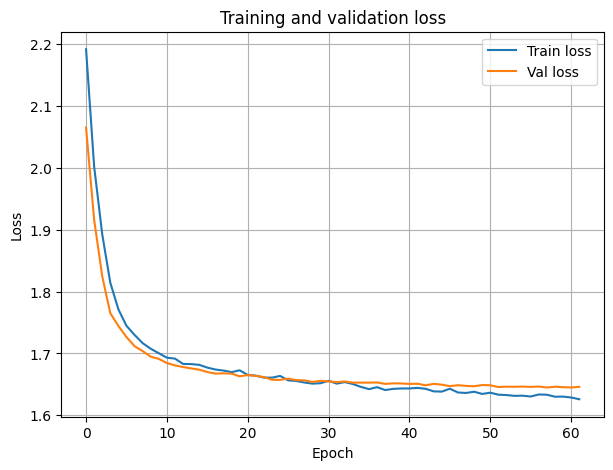

In [44]:
Plots.loss_plot(train_losses, val_losses)

In [45]:
# Compute train and validation accuracy
model.eval()
mlp_train_acc = compute_accuracy(model, train_loader, device)
mlp_val_acc = compute_accuracy(model, val_loader, device)

### Convolutional neural network

In [46]:
train_loader, val_loader = build_data_loaders(
    X_train_reduced.reshape(-1, 1, 5, 2),
    y_train_onehot,
    X_val_reduced.reshape(-1, 1, 5, 2),
    y_val_onehot,
    64,
    torch.float32,
    torch.float32
)

In [47]:
pre_hidden_dim = 64
hidden_dim = 64
output_dim = 10
n_mlp_layers=2
conv_activation=nn.ReLU
mlp_activation=nn.ReLU
dropout=0.0

model = CNN(pre_hidden_dim, hidden_dim, output_dim, n_mlp_layers, conv_activation, mlp_activation, dropout).to(device)
print(f"Number of parameters: {model.num_params:.2E}")

Number of parameters: 2.40E+04


In [48]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4, betas=(0.99, 0.999))
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

train_losses, val_losses, lr_evolution = train(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    criterion = nn.CrossEntropyLoss(),
    optimizer = optimizer,
    lr_scheduler = lr_scheduler,
    n_epochs = 150,
    grad_clip = 1.0,
    device = device
)

Progress:  43%|████▎     | 65/150 [00:16<00:22,  3.85it/s, Train Loss=2.2, Val Loss=2.21] 

Early stopping triggered!


Final training loss: 2.1988170115152994
Final validation loss: 2.206714884440104


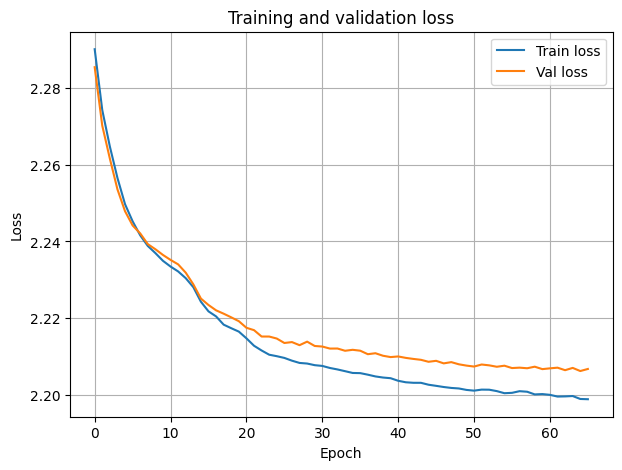

In [49]:
Plots.loss_plot(train_losses, val_losses)

In [50]:
model.eval()
cnn_train_acc = compute_accuracy(model, train_loader, device)
cnn_val_acc = compute_accuracy(model, val_loader, device)

#### Comparison

In [51]:
table = [
    ['SVM (Linear)', 100*accuracy_score(y_train, y_pred_train_linear), 100*accuracy_score(y_val, y_pred_val_linear)],
    ['SVM (Poly)', 100*accuracy_score(y_train, y_pred_train_poly3), 100*accuracy_score(y_val, y_pred_val_poly3)],
    ['SVM (Gaussian)', 100*accuracy_score(y_train, y_pred_train_gaussian), 100*accuracy_score(y_val, y_pred_val_gaussian)],
    ['SVM (Sigmoid)', 100*accuracy_score(y_train, y_pred_train_sigmoid), 100*accuracy_score(y_val, y_pred_val_sigmoid)],
    ['MLP', 100*mlp_train_acc, 100*mlp_val_acc],
    ['CNN', 100*cnn_train_acc, 100*cnn_val_acc]
]

print(tabulate(table, headers=['Model', 'Training Accuracy', 'Validation Accuracy'], tablefmt='fancy_grid', floatfmt='.1f'))

╒════════════════╤═════════════════════╤═══════════════════════╕
│ Model          │   Training Accuracy │   Validation Accuracy │
╞════════════════╪═════════════════════╪═══════════════════════╡
│ SVM (Linear)   │                78.0 │                  76.4 │
├────────────────┼─────────────────────┼───────────────────────┤
│ SVM (Poly)     │                83.2 │                  80.4 │
├────────────────┼─────────────────────┼───────────────────────┤
│ SVM (Gaussian) │                83.6 │                  81.1 │
├────────────────┼─────────────────────┼───────────────────────┤
│ SVM (Sigmoid)  │                65.2 │                  64.5 │
├────────────────┼─────────────────────┼───────────────────────┤
│ MLP            │                86.8 │                  81.7 │
├────────────────┼─────────────────────┼───────────────────────┤
│ CNN            │                84.1 │                  77.9 │
╘════════════════╧═════════════════════╧═══════════════════════╛
